# Implement name classifier
1. With `GPU`
2. With `data parallel`
3. Use `pad-pack`

In [1]:
import typing
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from utils import *

torch.manual_seed(1249583)

# See the details in `Dataset` section
SEQUENCE_LENGTH = 19
COUNTRY_LENGTH = 18

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [68]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    This function has one line different from the ordinary `train()` function
    It has `make_variables()` to convert tuple of names to be a tensor
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = make_var(data)        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        tmp = output.view(-1, COUNTRY_LENGTH)
        loss = criterion(tmp, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = make_var(data)
            data, target = data.to(device), target.to(device)
            output = model(data)
            tmp = output.view(-1, COUNTRY_LENGTH)
            
            test_loss += criterion(tmp, target).item() # sum up batch loss
            pred = tmp.max(1, keepdim=True)[1] # get the index of the max log-probability

            pred_tmp = pred.view(-1)
            pred_list = pred_tmp.tolist()
            target_list = target.tolist()
            
            y_test += target_list
            y_pred += pred_list
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=test_loader.dataset.countries, normalize=True,
                          title='Confusion matrix')


In [3]:
tmp = make_var(['Tiras', 'Ann', 'El'])
tmp

tensor([[116, 105, 114,  97, 115],
        [ 97, 110, 110,   0,   0],
        [101, 108,   0,   0,   0]])

In [4]:
lengths = count_non_zero_length(tmp)
lengths

[5, 3, 2]

In [5]:
emb = nn.Embedding(128, 5)

In [6]:
embedding = emb(tmp)
embedding

tensor([[[ 0.4704, -0.9117, -0.3375, -0.0884,  0.1998],
         [ 0.5264,  1.1494, -0.0344,  1.2120, -0.6235],
         [ 0.6469, -0.4744,  0.7591,  2.6530, -0.3358],
         [ 0.1828,  0.1441,  1.1485, -0.2379, -0.7293],
         [-0.1121, -0.9048, -1.3277, -0.6784,  0.6686]],

        [[ 0.1828,  0.1441,  1.1485, -0.2379, -0.7293],
         [ 0.6071, -0.4406,  0.1286, -0.6159,  1.3301],
         [ 0.6071, -0.4406,  0.1286, -0.6159,  1.3301],
         [-0.1570,  0.5740, -1.0368, -0.1413, -0.2990],
         [-0.1570,  0.5740, -1.0368, -0.1413, -0.2990]],

        [[-1.1611, -1.2032, -0.4672,  0.5582,  1.0478],
         [ 0.0588,  0.4291, -0.5033, -0.1797,  1.8511],
         [-0.1570,  0.5740, -1.0368, -0.1413, -0.2990],
         [-0.1570,  0.5740, -1.0368, -0.1413, -0.2990],
         [-0.1570,  0.5740, -1.0368, -0.1413, -0.2990]]],
       grad_fn=<EmbeddingBackward>)

In [7]:
embedding.size()

torch.Size([3, 5, 5])

In [8]:
from pprint import pprint

pps_in = torch.nn.utils.rnn.pack_padded_sequence(embedding, batch_first=True, lengths=lengths)
pps_in

PackedSequence(data=tensor([[ 0.4704, -0.9117, -0.3375, -0.0884,  0.1998],
        [ 0.1828,  0.1441,  1.1485, -0.2379, -0.7293],
        [-1.1611, -1.2032, -0.4672,  0.5582,  1.0478],
        [ 0.5264,  1.1494, -0.0344,  1.2120, -0.6235],
        [ 0.6071, -0.4406,  0.1286, -0.6159,  1.3301],
        [ 0.0588,  0.4291, -0.5033, -0.1797,  1.8511],
        [ 0.6469, -0.4744,  0.7591,  2.6530, -0.3358],
        [ 0.6071, -0.4406,  0.1286, -0.6159,  1.3301],
        [ 0.1828,  0.1441,  1.1485, -0.2379, -0.7293],
        [-0.1121, -0.9048, -1.3277, -0.6784,  0.6686]],
       grad_fn=<PackPaddedSequenceBackward>), batch_sizes=tensor([3, 3, 2, 1, 1]))

In [9]:
pps_out = torch.nn.utils.rnn.pad_packed_sequence(pps_in, batch_first=True)
pps_out

(tensor([[[ 0.4704, -0.9117, -0.3375, -0.0884,  0.1998],
          [ 0.5264,  1.1494, -0.0344,  1.2120, -0.6235],
          [ 0.6469, -0.4744,  0.7591,  2.6530, -0.3358],
          [ 0.1828,  0.1441,  1.1485, -0.2379, -0.7293],
          [-0.1121, -0.9048, -1.3277, -0.6784,  0.6686]],
 
         [[ 0.1828,  0.1441,  1.1485, -0.2379, -0.7293],
          [ 0.6071, -0.4406,  0.1286, -0.6159,  1.3301],
          [ 0.6071, -0.4406,  0.1286, -0.6159,  1.3301],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[-1.1611, -1.2032, -0.4672,  0.5582,  1.0478],
          [ 0.0588,  0.4291, -0.5033, -0.1797,  1.8511],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
        grad_fn=<TransposeBackward0>), tensor([5, 3, 2]))

In [10]:
gru = nn.GRU(5, 18, 2)

In [11]:
pps_out_n_size, ht = gru(pps_in)

In [12]:
result = torch.nn.utils.rnn.pad_packed_sequence(pps_out_n_size, batch_first=True)

In [13]:
result

(tensor([[[ 6.2580e-02, -6.3315e-02,  2.8246e-02,  1.1329e-02,  1.9272e-01,
            1.2364e-02,  1.4054e-01,  4.6680e-02, -6.6380e-02,  1.9231e-02,
            8.7757e-02, -3.8589e-02,  1.5547e-01, -7.2058e-02, -1.0882e-01,
           -3.3230e-02, -1.0175e-01, -7.5950e-02],
          [ 3.4298e-02, -6.6681e-02,  5.4977e-02,  4.8175e-02,  2.3772e-01,
           -5.4047e-02,  1.7810e-01,  8.9667e-02, -6.4322e-02, -5.6588e-02,
            1.8398e-01, -8.8153e-02,  2.0674e-01, -1.5399e-01, -2.4321e-01,
           -1.2008e-01, -8.6368e-02, -2.1150e-02],
          [ 1.9094e-02, -5.9465e-02,  1.2853e-02,  1.3244e-01,  2.9835e-01,
           -1.0988e-01,  2.5128e-01,  1.6941e-01, -7.1983e-02, -1.0381e-01,
            2.8499e-01, -1.2735e-01,  2.4716e-01, -2.5259e-01, -3.0362e-01,
           -2.3619e-01, -1.5242e-03,  9.3280e-02],
          [ 4.3776e-03, -7.7980e-02,  2.5108e-02,  1.1384e-01,  2.9743e-01,
           -9.9611e-02,  2.7944e-01,  1.9086e-01, -3.7785e-02, -9.5726e-02,
           

In [85]:
class ModelX(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii. It has to use `input_size=128, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        lengths = count_non_zero_length(input)
        
        # Embedding S x B -> S x B x I (embedding size)
        # print(f" input size: {input.size()}")
        embedded = self.embedding(input).to(self.device)
#         embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        # print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        
        pps_in = torch.nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=lengths)
        packed_output, hidden = self.gru(pps_in, hidden)
        # print(f" gru hidden output: {hidden.size()}")
        
        # This line is no need. Because I use `hidden` as an output
        # result, pps_out_size = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        # print(f" fc output: {fc_output.size()}")
#         import ipdb; ipdb.set_trace()
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(DEVICE)

In [86]:
# classifier = RNNClassifier()
classifier = ModelX()
arr, _ = str2ascii_arr('adylov')
inp = torch.tensor([arr], dtype=torch.long)
out = classifier(inp)
print(f"\nin: {inp.size()}, \nout: {out.size()}")


in: torch.Size([1, 6]), 
out: torch.Size([1, 1, 18])


In [87]:
names = ['adylov', 'solan', 'hard', 'san']
# classifier = RNNClassifier()
classifier = ModelX()
inputs = make_var(names)
out = classifier(inputs)
print(f"\nbatch in: {inputs.size()}, \nbatch out: {out.size()}")


batch in: torch.Size([4, 6]), 
batch out: torch.Size([1, 4, 18])


In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii. It has to use `input_size=128, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(128, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        
        # Sung Kim run this all at once (over the whole input sequence)
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        
        # input: B x S -- (transpose) --> S x B
        input = input.t()
        
        # Embedding S x B -> S x B x I (embedding size)
        print(f" input size: {input.size()}")
        embedded = self.embedding(input)
        embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        output, hidden = self.gru(embedded, hidden)
        print(f" gru hidden output: {hidden.size()}")
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        print(f" fc output: {fc_output.size()}")
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(self.device)

# Dataset

In [16]:
class NameDataSet(Dataset):
    def __init__(self, filename='names_train.csv'):
        trainset = pd.read_csv(filename, header=None)
        trainset.columns = ['name', 'country']
        countries = sorted(list(trainset.country.drop_duplicates()))

        self.trainset = trainset
        self.countries = countries
        self.len = len(trainset)        

    def __getitem__(self, index):
        country = self.trainset.iloc[index]['country']
        return self.trainset.iloc[index]['name'], self.countries.index(country)

    def __len__(self):
        return self.len
        

In [17]:
train_dataset = NameDataSet(filename='../lessons/names_train.csv')
test_dataset = NameDataSet(filename='../lessons/names_test.csv')

In [18]:
%%time
train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=2, num_workers=2) # 2 * 9 * 743 
test_loader = DataLoader(dataset=test_dataset, sampler=ImbalancedDatasetSampler(test_dataset), batch_size=2, num_workers=2) # 4 * 25 * 67


CPU times: user 8.61 s, sys: 10 ms, total: 8.62 s
Wall time: 8.62 s


# 1. Model

In [69]:
# model = RNNClassifier().to(DEVICE)

In [88]:
model = ModelX().to(DEVICE)

# 2. Criterion & Loss

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Epoch: 1 [0/13374 (0%)]	Loss: 2.864951
Train Epoch: 1 [2000/13374 (15%)]	Loss: 4.175035
Train Epoch: 1 [4000/13374 (30%)]	Loss: 1.719724
Train Epoch: 1 [6000/13374 (45%)]	Loss: 4.275517
Train Epoch: 1 [8000/13374 (60%)]	Loss: 1.976250
Train Epoch: 1 [10000/13374 (75%)]	Loss: 4.349190
Train Epoch: 1 [12000/13374 (90%)]	Loss: 3.634032



Test set: Average loss: 1.3298, Accuracy: 1662/6700 (25%)

[[127   9  47  11  18  11   5  26  10  24  30   9   6  19  16   3  20   6]
 [ 13  73  19   4  21  16  14   7  19  26  10  58   8   7  25   9   9  14]
 [ 18  15  78  11  16  31   9  14  16  17  32  20  12  15  14   9  23  23]
 [ 12  10  22  97  22  15  14  20   8  10  20  19   4  12  24  18  10   9]
 [ 21   8  32  15  82  31  12  13  26  16  16  36   2  16  24  15  10  17]
 [ 13  20  20  21  62  60  16  27  16  12  14  12   5   8  46  19   5  13]
 [ 12  12  40  34  39  24  64  13  22  12   8  11   1   8  21  19  10  15]
 [  8   5  11   9  20  17   4 169  10  26  23  18   2  19   8   5  11   9]
 [ 27  11  26  16  46  27   7  12  77  15  16  11   5  11  15   9  10  28]
 [  6  18   9   7  21  20   6  20  10 146  22   9   3  15  15   5  31   6]
 [  8  17  11   5  18  15   2  10  10  20 156  15   6  12  17   6  15  15]
 [ 21  13  24   3  12  30   8  12  14  57  15  60   2  14  18   2  18  40]
 [ 14   9  79  12  21  28   6  17  14  1

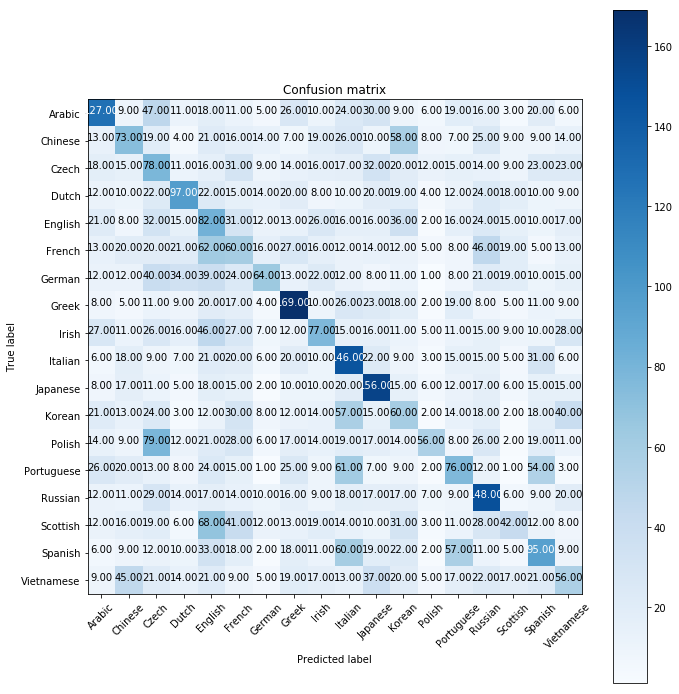

In [90]:
for epoch in tqdm(range(1, 1 + 1)):
    train(model, DEVICE, train_loader, optimizer, epoch, criterion)
    test(model, DEVICE, test_loader, criterion)

In [49]:
aa = ['an', 'catto', 'nicky', 'Tom']
sorted(aa, reverse=True, key=len)

['catto', 'nicky', 'Tom', 'an']